### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path

import altair as alt
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn import metrics

from stratx.partdep import (
    plot_catstratpd,
    plot_catstratpd_gridsearch,
    plot_stratpd,
    plot_stratpd_gridsearch,
)

plt.style.use("seaborn-talk")
shap.initjs()

In [3]:
from why import data, preprocessing

In [4]:
config_file = Path.cwd() / ".." / "resources" / "car_insurance_cold_calls.json"
with open(config_file, mode="r") as f:
    config = json.load(f)

### Read the training and test data

In [5]:
insurance_data = data.CarInsurance(
    config=config, datapath=Path.cwd() / ".." / "data" / "raw"
)
train, test = insurance_data.train, insurance_data.test

In [6]:
train.shape, test.shape

((4000, 18), (1000, 18))

In [7]:
train.head().T

Id,1,2,3,4,5
Age,32,32,29,25,30
Job,management,blue-collar,management,student,management
MaritalStatus,single,married,single,single,married
EducationLevel,tertiary,primary,tertiary,primary,tertiary
HasCreditDefault,no,no,no,no,no
Balance,1218,1156,637,373,2694
HasHHInsurance,yes,yes,yes,yes,no
HasCarLoan,no,no,no,no,no
CommunicationType,telephone,NaN,cellular,cellular,cellular
LastContactDayOfMonth,28,26,3,11,3


### Prepare the training data for model development

In [8]:
trans = preprocessing.InsuranceTransformer(config=config)
X_train, X_valid, y_train, y_valid = trans.prepare_train_valid(train)

### Analyze and filter the training data

In [9]:
drop_cols = ["LastCallDurationSecs", "LastCallHourOfDay", "LastContactMonth", "LastContactDayOfMonth"]
to_drop = [c for c in X_train.columns if any(d in c for d in drop_cols)]

In [10]:
X_train = X_train.pipe(preprocessing.remove_high_corrs, min_corr=1.0).drop(
    columns=to_drop, errors="ignore"
)

X_valid = X_valid.pipe(preprocessing.remove_high_corrs, min_corr=1.0).drop(
    columns=to_drop, errors="ignore"
)

### Fit a model

In [11]:
rf = RandomForestClassifier(
    n_estimators=20, min_samples_leaf=3, max_depth=12, n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [12]:
pd.DataFrame(
    {
        "Accuracy": [rf.score(X_train, y_train), rf.score(X_valid, y_valid)],
        "ROC AUC": [
            metrics.roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]),
            metrics.roc_auc_score(y_valid, rf.predict_proba(X_valid)[:, 1]),
        ],
    },
    index=["Training", "Validation"]
)

,Accuracy,ROC AUC
Training,0.775667,0.875007
Validation,0.717000,0.764206


### Global Explanations

In [13]:
feature_names = X_train.columns

#### Feature importance

##### Impurity based feature importance

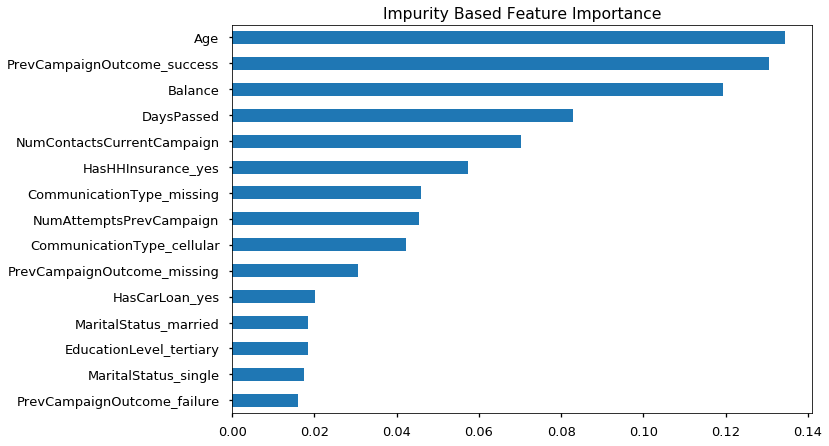

In [14]:
tree_feat_imp = pd.Series(rf.feature_importances_, index=feature_names)
tree_feat_imp.nlargest(15).sort_values().plot(
    kind="barh", title="Impurity Based Feature Importance"
)
plt.show()

##### Permutation feature importance

**On the validation set**

In [15]:
permutation_feat_imp_valid = permutation_importance(
    rf, X_valid.values, y_valid, n_repeats=10, n_jobs=-1
)

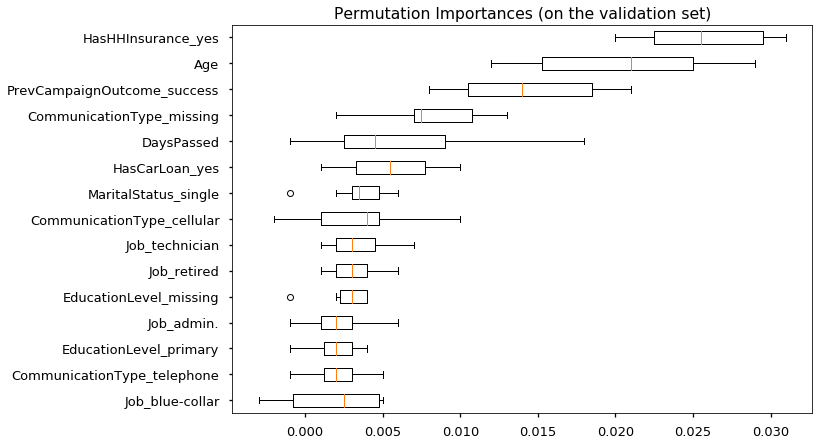

In [16]:
sorted_idx = permutation_feat_imp_valid.importances_mean.argsort()[-15:]

fig, ax = plt.subplots()
ax.boxplot(
    permutation_feat_imp_valid.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
ax.set_title("Permutation Importances (on the validation set)")
plt.show()

**On the training set**

In [17]:
permutation_feat_imp_train = permutation_importance(
    rf, X_train.values, y_train, n_repeats=10, n_jobs=-1
)

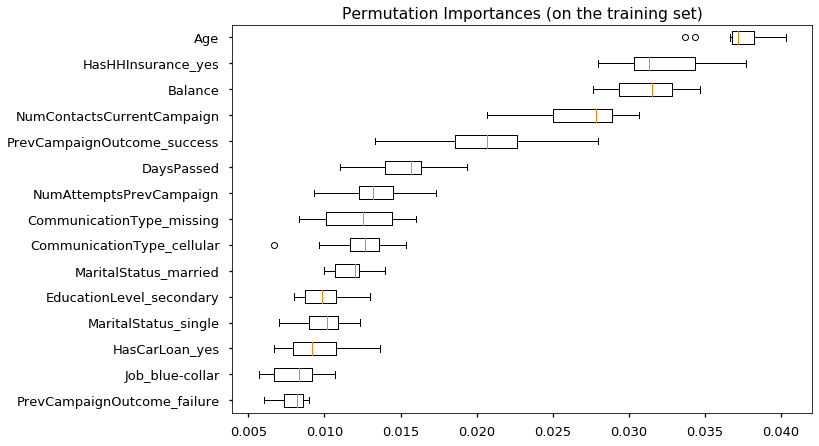

In [18]:
sorted_idx = permutation_feat_imp_train.importances_mean.argsort()[-15:]

fig, ax = plt.subplots()
ax.boxplot(
    permutation_feat_imp_train.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
ax.set_title("Permutation Importances (on the training set)")
plt.show()

##### Shap Feature Importance

In [19]:
explainer = shap.TreeExplainer(rf, X_valid)
shap_values = explainer.shap_values(X_valid)

100%|===================| 1998/2000 [02:01<00:00]        

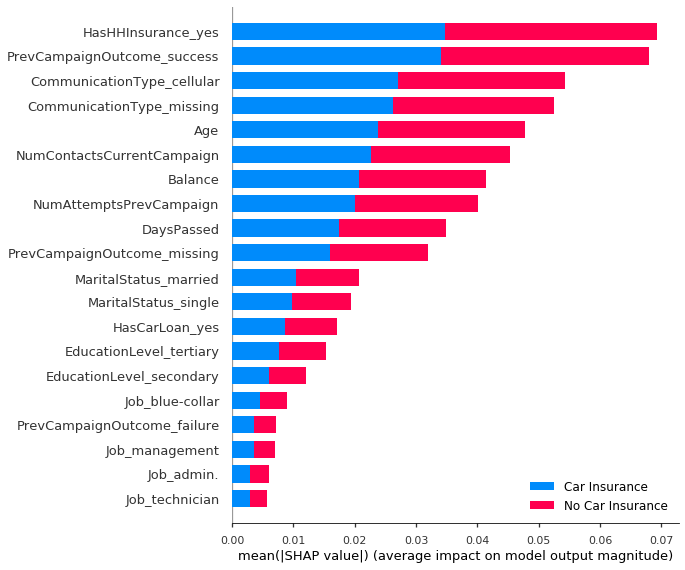

In [20]:
shap.summary_plot(shap_values, X_valid, class_names=["No Car Insurance", "Car Insurance"])

#### Partial Dependence Plots

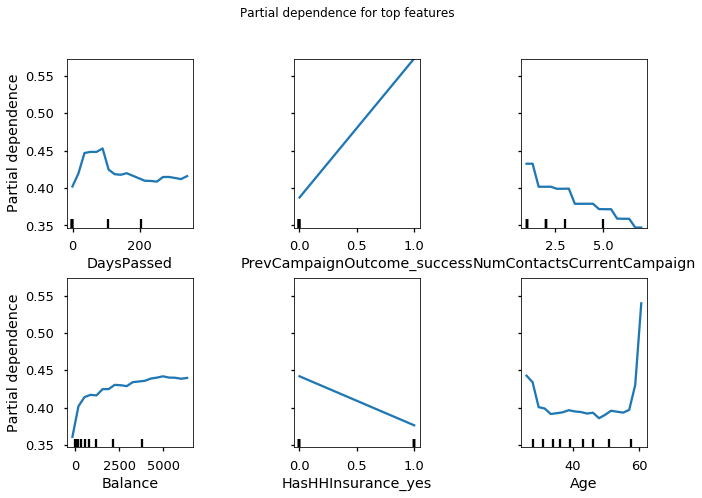

In [21]:
pdp_features = feature_names[sorted_idx][-6:]
plot_partial_dependence(
    rf, X_valid, features=pdp_features, feature_names=feature_names, grid_resolution=20
)
fig = plt.gcf()
fig.suptitle("Partial dependence for top features")
fig.subplots_adjust(wspace=0.8, hspace=0.3)

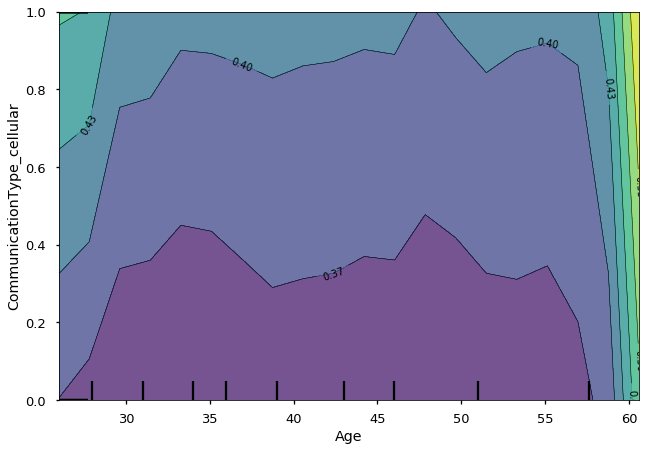

In [22]:
plot_partial_dependence(
    rf,
    X_valid,
    features=[("Age", "CommunicationType_cellular")],
    feature_names=feature_names,
    grid_resolution=20,
)
plt.show()

##### StratPD

###### Numerical features

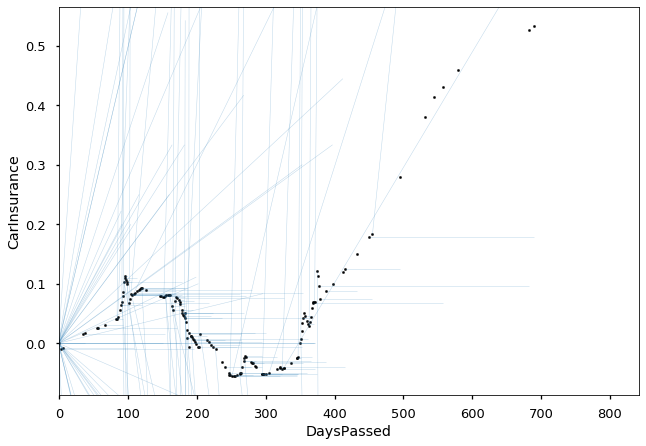

In [23]:
plot_stratpd(X_valid, y_valid, "DaysPassed", "CarInsurance", min_samples_leaf=10)
plt.show()

###### Categorical features

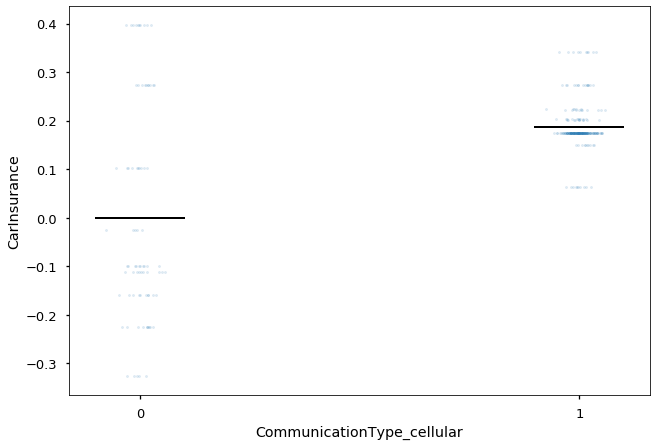

In [24]:
plot_catstratpd(
    X_valid,
    y_valid,
    "CommunicationType_cellular",
    "CarInsurance",
    min_samples_leaf=20,
    ntrees=10,
)
plt.show()

### Local Explanations

In [42]:
sample_ids = [0, 1, 2]
n_feats = 5

In [43]:
top_feat_ids = np.argsort(np.abs(shap_values[0][sample_ids, :]))[:, ::-1][:, :n_feats]
sample_p1s = np.round(rf.predict_proba(X_valid.iloc[sample_ids, :])[:, 1], 4)
sample_shaps = np.array(
    [ar[feats] for ar, feats in zip(shap_values[0][sample_ids], top_feat_ids)]
)

sample_feature_values = np.array(
    [
        [
            f"{c} = {v} ( {s:+.2f} )"
            for (c, v), s in zip(X_valid.iloc[sample, feats].iteritems(), shaps,)
        ]
        for sample, feats, shaps in zip(sample_ids, top_feat_ids, sample_shaps)
    ]
)

In [44]:
pd.DataFrame(sample_feature_values, columns=[f"Feature {i+1}" for i in range(n_feats)]).assign(Prediction=sample_p1s)

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Prediction
0,CommunicationType_missing = 1.0 ( +0.09 ),CommunicationType_cellular = 0.0 ( +0.05 ),HasHHInsurance_yes = 0.0 ( -0.02 ),NumAttemptsPrevCampaign = 0.0 ( +0.02 ),EducationLevel_primary = 1.0 ( +0.02 ),0.1271
1,CommunicationType_missing = 1.0 ( +0.06 ),CommunicationType_cellular = 0.0 ( +0.04 ),PrevCampaignOutcome_success = 0.0 ( +0.02 ),HasHHInsurance_yes = 1.0 ( +0.02 ),Job_admin. = 1.0 ( -0.02 ),0.1906
2,CommunicationType_missing = 1.0 ( +0.05 ),CommunicationType_cellular = 0.0 ( +0.05 ),HasHHInsurance_yes = 0.0 ( -0.04 ),Balance = 246.0 ( -0.03 ),NumAttemptsPrevCampaign = 0.0 ( +0.02 ),0.2595


### Experiments

In [45]:
bins = np.arange(-1., 1.1, 0.25)
labels = ["----", "---", "--", "-", "+", "++", "+++", "++++"]

In [46]:
row_sums = np.abs(sample_shaps).sum(axis=1)
sample_shaps_relative = sample_shaps / row_sums[:, np.newaxis]

sample_feature_values = np.array(
    [
        [
            f"{c} = {v} ( {s} )"
            for (c, v), s in zip(
                X_valid.iloc[sample, feats].iteritems(),
                pd.cut(shaps, bins=bins, labels=labels, include_lowest=True).astype(
                    str
                ),
            )
        ]
        for sample, feats, shaps in zip(sample_ids, top_feat_ids, sample_shaps_relative)
    ]
)

In [47]:
df = pd.DataFrame(sample_shaps, columns=[f"Feature {i+1}" for i in range(n_feats)]).round(2)

In [48]:
df.style.bar(axis=None, align="mid", color=["#d65f5f", "#5fba7d"], width=100)

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5
0,0.09,0.05,-0.02,0.02,0.02
1,0.06,0.04,0.02,0.02,-0.02
2,0.05,0.05,-0.04,-0.03,0.02
